# Homework 10

The block below imports the necessary packages.

In [1]:
import numpy as np
import pandas as pd
import pylab as plt

In this assignment, you will work with the Dow dataset and MNIST dataset. Both datasets are provided below.

In [2]:
# Dow Dataset
df = pd.read_excel('impurity_dataset-training.xlsx')

def is_real_and_finite(x):
    if not np.isreal(x):
        return False
    elif not np.isfinite(x):
        return False
    else:
        return True
    
all_data = df[df.columns[1:]].values
numeric_map = df[df.columns[1:]].applymap(is_real_and_finite)
real_rows = numeric_map.all(axis = 1).copy().values
X_dow = np.array(all_data[real_rows, :-5], dtype = 'float')
y_dow = np.array(all_data[real_rows, -3], dtype = 'float')
y = y_dow.reshape(-1, 1)

# MNIST Dataset
from sklearn.datasets import load_digits

digits = load_digits()

X_mnist = np.array(digits.data)
y_mnist = np.array(digits.target)

## 1. Visualizing k-Means

You will compare the custom `kmeans` function you've defined in the Skill Check and from the lectures to the built-in `sklearn.cluster.KMeans` function. Let's first proceed with data preprocessing.

### 1a: TSNE

Use TSNE on `X_dow` and reduce its dimensionality to 2. You may use the default hyperparameters, or select your own.

In [3]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2)
X_tsne = tsne.fit_transform(X_dow)

/usr/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


### 1b: Custom-coded `kmeans`

Pass the TSNE-trasnformed data and initial guess defined below to the `kmeans` function from the Skill Check and lectures. Plot the result of clustering by color-coding the points. Locate the cluster centers using \* markers (`marker = '*'`).

In [4]:
centers = [[5, 0], [7, 5], [100, 100], [15, 20]]

def dist(pt1, pt2):
    return np.sqrt(sum([(xi - yi)**2 for xi, yi in zip(pt1, pt2)]))

def expected_assignment(pt, cluster_centers):
    dists = [dist(pt, ci) for ci in cluster_centers]
    min_index = dists.index(min(dists))
    return min_index

def new_centers(cluster_points, centers):
    centers = list(centers)
    for i, ci in enumerate(cluster_points):
        if ci != []:
            centers[i] = np.mean(ci, axis = 0)
    return centers

def kmeans(X, centers, tol = 0.1):
    old_center = np.array(centers)
    max_dist = 1e6
    
    while max_dist > tol:
        clusters = []
        for i in range(old_center.shape[0]):
            clusters.append([])
            
        for pt in X:
            cluster_idx = expected_assignment(pt, old_center)
            clusters[cluster_idx].append(pt)
            
        new_center = new_centers(clusters, old_center)
        
        max_dist = 0
        for i in range(old_center.shape[0]):
            dist = np.linalg.norm(old_center[i] - new_center[i])
            if max_dist < dist:
                max_dist = dist
                
        old_center = np.array(new_center)
    return np.array(new_center), clusters

In [5]:
clrs = np.array(['#003057', '#EAAA00', '#4B8B9B', '#B3A369', '#377117', '#1879DB', '#8E8B76', '#F5D580', '#002233', '#808080'])

In [6]:
new_center, clusters = kmeans(X_tsne, centers)

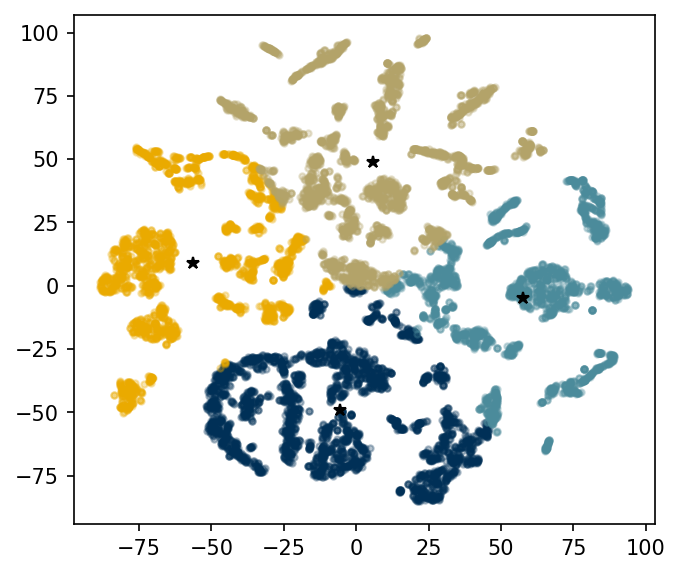

In [7]:
fig, ax = plt.subplots(figsize = (5, 4.5), dpi = 150)

for i, ci in enumerate(clusters):
    for pt in ci:
        ax.plot(pt[0], pt[1], marker = '.', alpha = 0.3, color = clrs[i])

for i in range(4):
    ax.plot(new_center[i][0], new_center[i][1], marker = '*', color = 'k')

### 1c: scikit-learn KMeans

Use the built-in `sklearn.cluster.KMeans` model to perform k-means clustering. Set `n_clusters` to 4. Plot the result of clustering by color-coding the points. Locate the cluster centers using \* markers (`marker = '*'`).

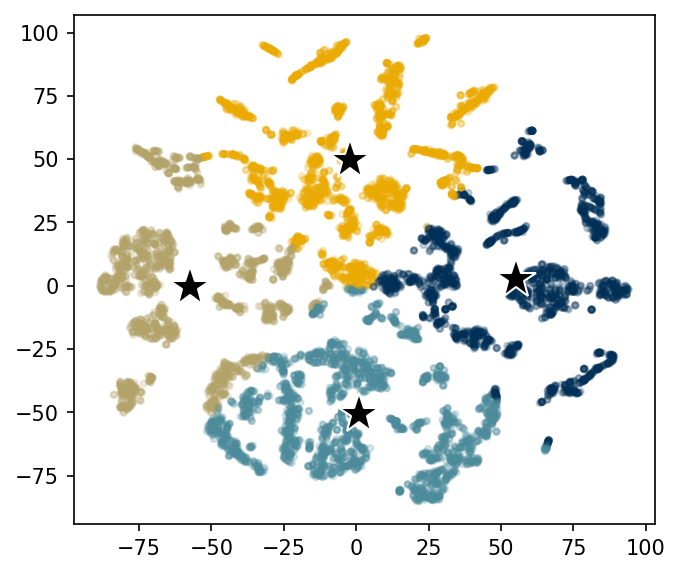

In [8]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 4)
y_tsne = kmeans.fit_predict(X_tsne)
centers = kmeans.cluster_centers_

fig, ax = plt.subplots(figsize = (5, 4.5), dpi = 150)
ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c = clrs[y_tsne], marker = '.', alpha = .2)

for center in centers:
    x_i = center[0]
    y_i = center[1]
    ax.plot(x_i, y_i, marker = '*', color = 'k', mec = 'w', markersize = 20)

### 1d: Discussion


Do the results of your implementation match the scikit-learn implementation? If not, briefly explain at least one difference that could cause the discrepancy.

**Answer**

- Our custom-coded k-means clustering uses `tol = 0.1` whereas the built-in function uses `tol = 0.0001` by default.
- The built-in k-means utilizes the different EM algorithm called the **Elkan** algorithm. ([reference](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html))

## 2. Generative Model for Handwritten Digits

In this problem, you will generate a synthetic handwritten digit derived from the MNIST dataset by kernel density estimation.

### 2a: Data selection

Choose a single number from 0 to 9 and select the points labeled as your choice in the MNIST dataset.

In [9]:
X_mnist_8 = X_mnist[y_mnist == 8]

### 2b: KDE

Train a kernel density estimation model with `sklearn.neighbors.KernelDensity` using `kernel = Gaussian` and `bandwidth = 0.35`.

In [10]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(kernel = 'gaussian', bandwidth = 0.35)
kde.fit(X_mnist_8);

### 2c: Visualize synthetic digits

Visualize 3 examples of a synthetic digit generated by the KDE model.

In [11]:
def show_image(digit_data, n, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    img = digit_data[n].reshape(8,8)
    colormap = ax.imshow(img,cmap='binary',vmin=0,vmax=16)
    ax.get_figure().colorbar(colormap, ax=ax)

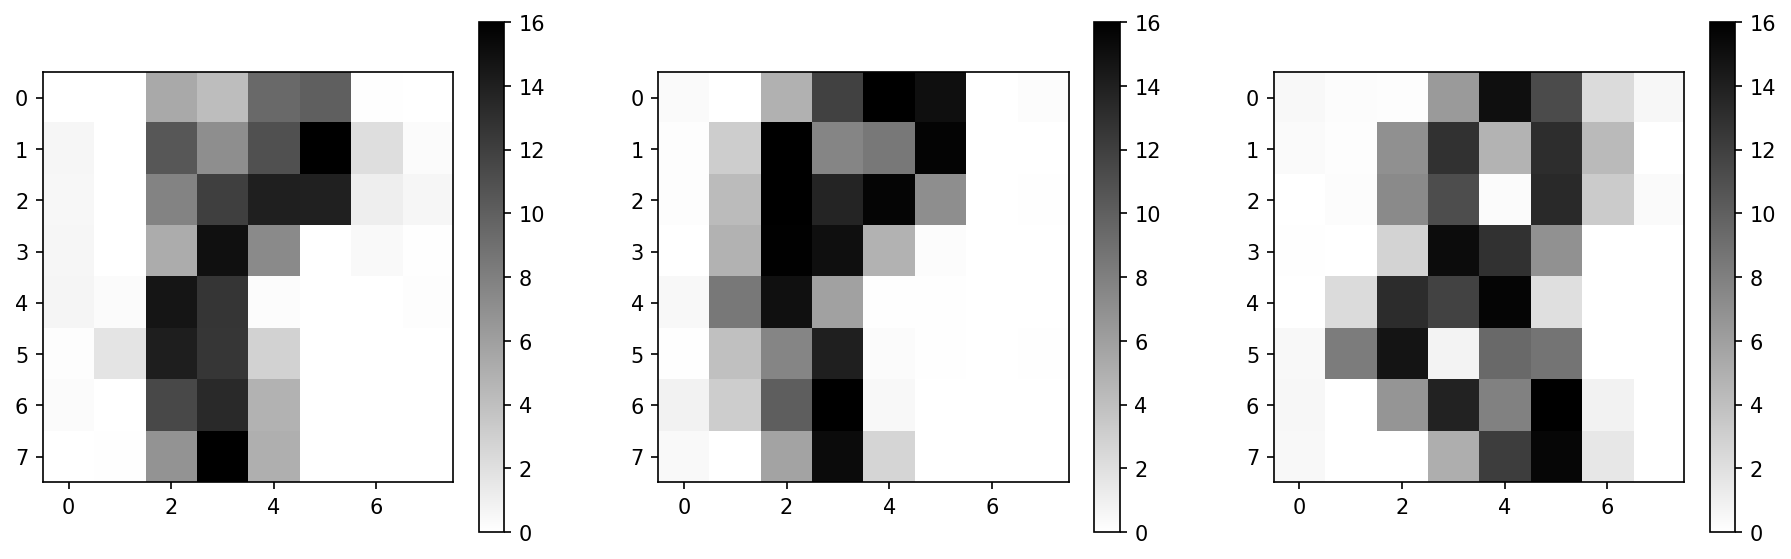

In [12]:
fig, axes = plt.subplots(1, 3, figsize = (15, 4.5), dpi = 150)
samples = kde.sample(3)

for i, ax in enumerate(axes):
    show_image(samples, i, ax = axes[i])

## 3. GMM vs. KDE (6745 only)

The Gaussian function takes part in both GMM and KDE with `Gaussian` kernel. In a Bayesian classification scheme, which model (GMM or KDE) would you expect to perform better for the MNIST dataset? Briefly explain.

**If you are in the 4745 section, write that you are not required to answer to this question in the below block.**

KDE would perform better than GMM in a Bayesian classification scheme. In this scheme, it is important to get a very reliable class-conditional probability density functions of a finite continuous data. KDE is more flexible in terms of estimating probability density functions (PDF) since GMMs assume that the data follows a normal distribution.